## Context

Two time series with recurring data from FRED (Federal Reserve Economic Data) have been selected. On one hand, we have the variable "date," and on the other, the University of Michigan Consumer Sentiment Index. This index is a measure of consumer confidence in the U.S. economy. It is based on surveys that ask consumers about their current perceptions and attitudes towards personal finances, general economic conditions, and intentions to purchase durable goods. High values indicate a higher level of consumer confidence, which is generally considered positive for consumer spending and, therefore, for the economy.

The third variable will be Industrial Production. This series measures the actual output of all facilities in the U.S. manufacturing sector based on the North American Industry Classification System (NAICS). It is an important indicator of economic health, as it reflects the level of activity in factories, mines, and utilities. An increase in industrial production suggests economic growth, while a decrease may indicate an economic contraction.

The goal is to predict future trends using the information from both graphs.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import minmax_scale

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Lambda
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns
import time

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
seed=42

sns.set_style('whitegrid')
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
results_path = Path('results', 'time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

## 1. Data Loading / Analysis / Preprocessing / Visualization

Throughout the training and evaluation of the models, I have encountered some points that I find interesting regarding the dataset and the approach described in this text. I think it’s worth writing them down and supporting the information with evidence, using different variations of the dataset and strategies for making predictions. I primarily aim to discuss two points:

1. Structure of the Time Series: The time series is defined for the years 1980 to 2023. As seen in the figures displaying the time series, both for the sentiment variable and the ip variable (the latter perhaps being more visibly affected), there are at least two moments when the variable values change drastically. One corresponds to the 2008 financial crisis, and the other to the COVID-19 pandemic in 2020.

We will try to make predictions using data from the last six months for future months close to the year 2020. I believe this impacts the models' ability to predict those months in 2022 and 2023. As we will observe, the loss values for the validation set (val_loss) are consistently higher than those for the training set. The latter is affected by dropout in the recurrent network layers, while the former is not.

When I trained the models for the first time, I found this curious. Upon reviewing the time series, I think the problem may lie in the drastic changes in the series shortly before the values we try to predict—especially for the sentiment variable (which has a major change during COVID-19 and another in 2022), less so for the ip variable. To confirm this, I retrained one of the models (RNNsimple) but using data only up to 2019. I observed that the apparent overfitting issue (which I believe is caused by those drastic changes in the time series, leading to a lack of stable structure between the training and test sets) disappears.

Since addressing the time series structure is not the goal of this text, I won’t delve into this too deeply. However, I find it interesting to note how the models and their generalization capabilities appear to be clearly sensitive to this. To illustrate this point (and although I noticed similar behavior across all models shown here), I will show one example of training and testing with the dataset "trimmed" before 2020 in the RNNsimple network section.

2. Using Two Variables to Train the Model and Predicting Two Variables Simultaneously
The instructions ask us to handle the dataset in a unified way, feeding both variables (sentiment and ip) to the models simultaneously. This means that each instance of input sequences X has a structure of (6,2), and each y instance (i.e., the labels) has a structure of (2).

Initially, I expected that using two variables would be advantageous for the models. However, the results I found with the models required in the instructions are either satisfactory for only one of the two variables or poor for both. Although I’m not entirely certain, I suspect the models may somehow be mixing the information from the two variables. Given that these variables do not fully correlate during the two years we are asked to predict (from May 2022 onward, sentiment tends to increase while ip decreases), the prediction results are generally poor.

To illustrate this point, for the RNNsimple model, I show one version where both variables are trained and predicted simultaneously, along with two additional versions where the models are trained and predictions are made for each variable separately.

In [6]:
# Data loading
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1980', '2023-12').dropna()
df.columns = ['sentiment', 'ip']
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 528 entries, 1980-01-01 to 2023-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentiment  528 non-null    float64
 1   ip         528 non-null    float64
dtypes: float64(2)
memory usage: 12.4 KB


,sentiment,ip
DATE,,
1980-01-01,67.0,45.8562
1980-02-01,66.9,46.9435
1980-03-01,56.5,47.5013
1980-04-01,52.7,46.1175
1980-05-01,51.7,44.7997


In [7]:
# Check NAs in "sentiment"
df.loc[df["sentiment"].isnull()==True]

,sentiment,ip
DATE,,


In [8]:
# Check NAs in "ip"
df.loc[df["ip"].isnull()==True]

,sentiment,ip
DATE,,


In [9]:
# Set the number of months for which we want to calculate the difference (1 year)
periods = 12

# Get the logarithm of each value and calculate the 12-month difference
df["diff_log_sentiment"] = np.log(df["sentiment"]).diff(periods=periods)
df["diff_log_ip"] = np.log(df["ip"]).diff(periods=periods)

# Min-max scaling
max_sentiment = df["diff_log_sentiment"].max()
min_sentiment = df["diff_log_sentiment"].min()

max_ip = df["diff_log_ip"].max()
min_ip = df["diff_log_ip"].min()

df["min-max_sentiment"] = (df["diff_log_sentiment"] - min_sentiment) / (max_sentiment - min_sentiment)
df["min-max_ip"] = (df["diff_log_ip"] - min_ip) / (max_ip - min_ip)

In [10]:
df.head(24)

,sentiment,ip,diff_log_sentiment,diff_log_ip,min-max_sentiment,min-max_ip
DATE,,,,,,
1980-01-01,67.0,45.8562,NaN,NaN,NaN,NaN
1980-02-01,66.9,46.9435,NaN,NaN,NaN,NaN
1980-03-01,56.5,47.5013,NaN,NaN,NaN,NaN
1980-04-01,52.7,46.1175,NaN,NaN,NaN,NaN
1980-05-01,51.7,44.7997,NaN,NaN,NaN,NaN
1980-06-01,58.7,44.9905,NaN,NaN,NaN,NaN
1980-07-01,62.3,42.0545,NaN,NaN,NaN,NaN
1980-08-01,67.3,43.5527,NaN,NaN,NaN,NaN
1980-09-01,73.7,45.2613,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'min-max scaling')

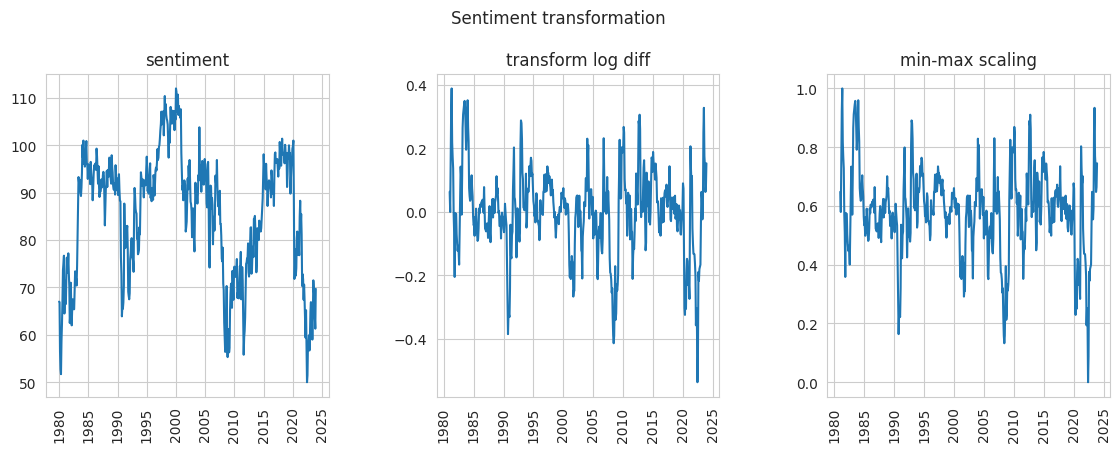

In [11]:
# Show the original "sentiment" time series and its transformations

fig, ax = plt.subplots(1, 3)
fig.suptitle("Sentiment transformation", y=1.05)
fig.tight_layout()
fig.set_size_inches(12, 4)
ax[0].plot(df["sentiment"])
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("sentiment")

ax[1].plot(df["diff_log_sentiment"])
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title("transform log diff")

ax[2].plot(df["min-max_sentiment"])
ax[2].tick_params(axis='x', rotation=90)
ax[2].set_title("min-max scaling")

Text(0.5, 1.0, 'min-max scaling')

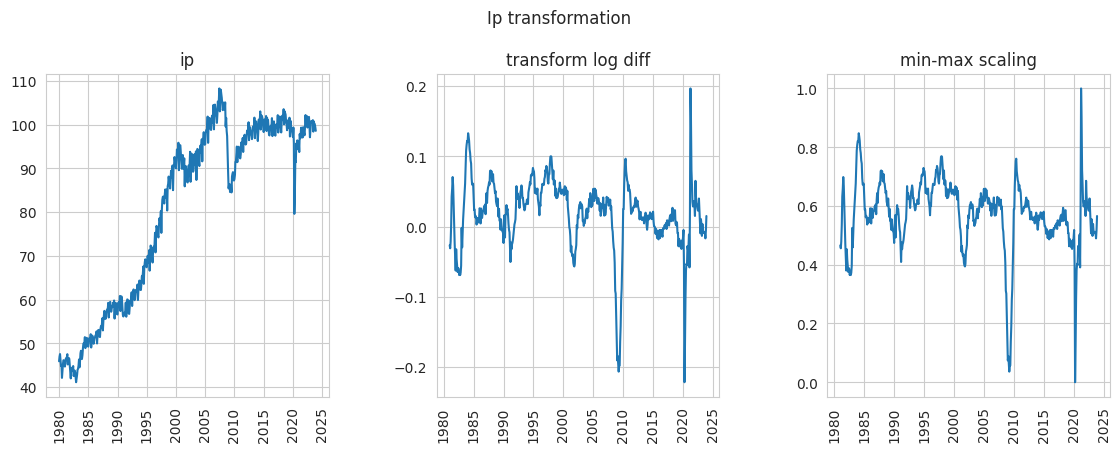

In [12]:
# Show the original "ip" time series and its transformations

fig, ax = plt.subplots(1, 3)
fig.suptitle("Ip transformation", y=1.05)
fig.tight_layout()
fig.set_size_inches(12, 4)
ax[0].plot(df["ip"])
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("ip")

ax[1].plot(df["diff_log_ip"])
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title("transform log diff")

ax[2].plot(df["min-max_ip"])
ax[2].tick_params(axis='x', rotation=90)
ax[2].set_title("min-max scaling")

In [13]:
# Finally, we keep only the transformed data

# Additionally, since the 12-month difference cannot be applied to the first
# 12 rows (as there is no data prior to 1980), these 12 rows are marked as NaN. Therefore, we remove them.

df = df[["min-max_sentiment", "min-max_ip"]].dropna()

In [14]:
# Show the first 13 months of data
df.head(13)

,min-max_sentiment,min-max_ip
DATE,,
1981-01-01,0.648259,0.465891
1981-02-01,0.579549,0.455921
1981-03-01,0.755588,0.478975
1981-04-01,0.922628,0.535938
1981-05-01,1.000000,0.631726
1981-06-01,0.816544,0.658569
1981-07-01,0.766923,0.698415
1981-08-01,0.727802,0.668894
1981-09-01,0.570718,0.599701


## 2. Data Preparation for Multivariable Model
Once we have preprocessed the data, we will prepare it in the specific format required by a recurrent neural network. To do so, I will:

1. Define and apply a function `create_multivariate_rnn_data`> that transforms the dataset df created above into a format suitable for training a recurrent model. The function should take the dataset and the window size (`window_size`) as input and return a data structure containing the input sequences (X) and target labels (y).
  
2. Use a `window_size` of 6 months to create the X and y datasets and verify the dimensions of the resulting datasets to ensure the transformation was performed correctly.

3. Split the transformed data into training and test sets, using the last 24 months of data as the test set. Besides, I will ensure that both the input data (X_train, X_test) and the labels (y_train, y_test) are correctly partitioned.








In [15]:
# We define the function to split the data and generate the input sequences and target labels.
def create_multivariate_rnn_data(df, window_size):
    """
    For two variables (X and y, both as lists) already created, the function takes a dataframe and a window_size as input.

    For the variable X, the function returns sequences of 6 records (dates) and two variables (sentiment and ip).
    For the variable y, the function returns a single record with two variables corresponding to the record immediately following the last record in each sequence of X:
    
    If we have records 0, 1, 2, 3, 4, 5, 6, 7, 8, and 9, the function will return the variables X and y with the following structure:
    [[0,1,2,3,4,5],
     [1,2,3,4,5,6],
     [2,3,4,5,6,7],
     [3,4,5,6,7,8]]
     
    y:
    [[6],
     [7],
     [8],
     [9]] 
    """
    train=[]
    test=[]
    for el in range(len(df)-window_size):
        train.append(np.array(df.iloc[el:el+window_size]))
        test.append(np.array(df.iloc[el+window_size]))
    return train, test

In [16]:
# Establish the desired window size
window_size = 6

# Vars to store sequences and labels
X = []
y = []

# Call the function to extract the data in the desired format
X, y = create_multivariate_rnn_data(df, window_size)

# Convert the lists to arrays to feed the NN
X = np.array(X)
y = np.array(y)

In [17]:
# Separate training and test sets
# The training set includes all labels except the last 24, as well as the sequences (X) needed to predict those labels.

# The test set includes the last 24 labels, as well as the sequences (X) needed to predict those labels.

X_train = X[0:-24]
X_test = X[-24:]

y_train = y[0:-24]
y_test = y[-24:]

In [18]:
# Check that the split is correct

# As a reference, show the values of the source dataframe between record -30 and -20.
df.tail(30).head(10)

,min-max_sentiment,min-max_ip
DATE,,
2021-07-01,0.701973,0.674225
2021-08-01,0.522680,0.613884
2021-09-01,0.472282,0.598145
2021-10-01,0.437186,0.603521
2021-11-01,0.437106,0.616007
2021-12-01,0.435110,0.600742
2022-01-01,0.404791,0.565950
2022-02-01,0.362148,0.685500
2022-03-01,0.193704,0.633995


The record 2022-01-01 0.404791 0.56594984 corresponds to the 24th, starting from the end. Therefore, this should be the first record of `y_test`

In [19]:
# Check the first record of `y_test`
y_test[0]

array([0.40479131, 0.56594984])

Vemos que el valor es correcto. Además, el registro anterior a este (esto es, 2021-12-01 0.435110 0.60074157) debería ser el último registro de la primera secuencia de `X_test`

In [20]:
X_test[0]

array([[0.70197264, 0.67422499],
       [0.52268033, 0.61388372],
       [0.47228165, 0.59814462],
       [0.43718607, 0.60352084],
       [0.43710574, 0.61600703],
       [0.43510989, 0.60074157]])

Again, the value is correct. Let's continue with the verification. The record 2021-12-01 0.435110 0.60074157 corresponds to the 25th, starting from the end. Therefore, this should be the last record of `y_train`

In [21]:
y_train[-1]

array([0.43510989, 0.60074157])

Again, the value is correct. Finally, the previous record (that is, 2021-11-01 0.437106 0.61600703) should be the last record of the last sequence of `X_train`

In [22]:
X_train[-1]

array([[0.6773403 , 0.72158213],
       [0.70197264, 0.67422499],
       [0.52268033, 0.61388372],
       [0.47228165, 0.59814462],
       [0.43718607, 0.60352084],
       [0.43710574, 0.61600703]])

**The values of `X_train`, `X_test`, `y_train`, and `y_test` are correct, and we can continue with the creation of models.**

## 2.1. Dataset preparation with data up to the end of 2019

As I stated above, I believe the structure of the time series changes drastically during 2020, and this affects the training and predictions for 2022 and 2023. To demonstrate this, I will train and use one of the models (the simple RNN) to predict with a trimmed dataset, such that the years 2018 and 2019 are used as the test set (y_test). I will keep the other parameters unchanged (subtracting the value from 12 months earlier during data transformation, a window_size of 6 units for the input sequences, 24 months in the test set for the labels, etc.).

In [23]:
# Loading data
df_short = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1980', '2019-12').dropna()
df_short.columns = ['sentiment', 'ip']

# Get the logarithm of each value and calculate the 12-month difference
df_short["diff_log_sentiment"] = np.log(df_short["sentiment"]).diff(periods=periods)
df_short["diff_log_ip"] = np.log(df_short["ip"]).diff(periods=periods)

# Min-max scaling
max_sentiment_short = df_short["diff_log_sentiment"].max()
min_sentiment_short = df_short["diff_log_sentiment"].min()

max_ip_short = df_short["diff_log_ip"].max()
min_ip_short = df_short["diff_log_ip"].min()

df_short["min-max_sentiment"] = (df_short["diff_log_sentiment"] - min_sentiment_short) / (max_sentiment_short - min_sentiment_short)
df_short["min-max_ip"] = (df_short["diff_log_ip"] - min_ip_short) / (max_ip_short - min_ip_short)

df_short = df_short[["min-max_sentiment", "min-max_ip"]].dropna()
df_short.tail(13)

,min-max_sentiment,min-max_ip
DATE,,
2018-12-01,0.546036,0.628477
2019-01-01,0.455265,0.623685
2019-02-01,0.439277,0.580760
2019-03-01,0.477847,0.580892
2019-04-01,0.494916,0.525941
2019-05-01,0.540412,0.557055
2019-06-01,0.515251,0.552471
2019-07-01,0.521595,0.525113
2019-08-01,0.429508,0.545406


In [24]:
# Vars to store sequences and labels
X_short = []
y_short = []

# Call the function to extract the data in the desired format
X_short, y_short = create_multivariate_rnn_data(df_short, window_size)

# Convert the lists to arrays to feed the NN
X_short = np.array(X_short)
y_short = np.array(y_short)

# Split in training and test sets
X_train_short = X_short[0:-24]
X_test_short = X_short[-24:]

y_train_short = y_short[0:-24]
y_test_short = y_short[-24:]

## 2.2. Preparation of datasets with data up to the end of 2023, but separating the two variables.

Also, as stated above, I want to explore the differences between training the models with both variables together and training them with the two variables separately. To do this, I will split the dataset into two parts, one for each variable, and I will train three different models for the simple RNN: one using the dataset with both variables combined, and two others, each using the dataset corresponding to a single variable.








In [25]:
# Vars to store sequences and labels for variable "sentiment"
X_sentiment = []
y_sentiment = []

# Vars to store sequences and labels for variable "ip"
X_ip = []
y_ip = []


# Call the function to extract the data in the desired format for var "sentiment"
X_sentiment, y_sentiment = create_multivariate_rnn_data(df["min-max_sentiment"], window_size)

# Call the function to extract the data in the desired format for var "ip"
X_ip, y_ip = create_multivariate_rnn_data(df["min-max_ip"], window_size)


# Convert the lists to arrays to feed the NN
X_sentiment = np.array(X_sentiment)
y_sentiment = np.array(y_sentiment)
X_ip = np.array(X_ip)
y_ip = np.array(y_ip)


# Split in training and test sets, var "sentiment"
X_train_sentiment = X_sentiment[0:-24]
X_test_sentiment = X_sentiment[-24:]

y_train_sentiment = y_sentiment[0:-24]
y_test_sentiment = y_sentiment[-24:]

# Split in training and test sets, var "ip"
X_train_ip = X_ip[0:-24]
X_test_ip = X_ip[-24:]

y_train_ip = y_ip[0:-24]
y_test_ip = y_ip[-24:]


In [26]:
# Show the structure of the resulting datasets for the var "sentiment"
print(X_train_sentiment.shape)
print(y_train_sentiment.shape)
print(X_test_sentiment.shape)
print(y_test_sentiment.shape)

(486, 6)
(486,)
(24, 6)
(24,)


In [27]:
# Show the structure of the resulting datasets for the var "ip"
print(X_train_ip.shape)
print(y_train_ip.shape)
print(X_test_ip.shape)
print(y_test_ip.shape)

(486, 6)
(486,)
(24, 6)
(24,)


## 3. RNN

Fist, I will build a RNN following the architecture described below:

1. I will add a SimpleRNN layer with a dropout rate of 0.1 for regularization to prevent overfitting. It is important to ensure that the RNN layer is configured not to return sequences, enabling a direct connection to the subsequent dense layers.

2. Set the number of input features (n_features) and the output size (output_size) of the model, both fixed at 2, corresponding to the two time series to be modeled.

3. onfigure the network's hyperparameters, including the number of units in the RNN layer (rnn_units=12) and the number of units in the dense layer (dense_units=6).

4. Include a dense layer with 'relu' activation followed by an output layer with 'linear' activation, suitable for regression tasks such as time series prediction.

5. Compile the model using 'RMSProp' as the optimizer and 'mae' (mean absolute error) as the loss function. This configuration is typically effective for regression problems where minimizing the absolute difference between predicted and actual values is the goal.

   


    
<strong>First, the model is presented using the complete dataset (up to December 2023) and leveraging both variables simultaneously for training and prediction.</strong>

In [28]:
K.clear_session()

# Input and output for all models with two variables
n_features = output_size = 2

# Define model
model_RNN_simple = Sequential()
model_RNN_simple.add(tf.keras.layers.Input(shape=(window_size,n_features)))
model_RNN_simple.add(tf.keras.layers.SimpleRNN(units=12, dropout=0.1, return_sequences=False))
model_RNN_simple.add(tf.keras.layers.Dense(units=6, activation="relu"))
model_RNN_simple.add(tf.keras.layers.Dense(units=output_size, activation="linear"))

In [29]:
# Compile the model
model_RNN_simple.compile(optimizer="RMSProp", loss="mae")
model_RNN_simple.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 12)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272 (1.06 KB)

 Trainable params: 272 (1.06 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
start = time.time()
# Training

# Callback for Early stopping
early_stopping_model_RNN_simple = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10)

# Callback for Model checkpoint
checkpoint_filepath = Path(results_path, 'rnn.h5.keras')

model_checkpoint_model_RNN_simple = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_loss",
    save_best_only=True)

# Train the model
history_model_RNN_simple = model_RNN_simple.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=20,
    callbacks=[early_stopping_model_RNN_simple, model_checkpoint_model_RNN_simple],
    shuffle=False,
    validation_data=(X_test, y_test))

print("Training time: "+str(time.time()-start)+" seconds")

Epoch 1/100


I0000 00:00:1734076339.316240      91 service.cc:145] XLA service 0x7934dc003fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734076339.316295      91 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:01 3s/step - loss: 0.6740

I0000 00:00:1734076340.936030      91 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.6113 - val_loss: 0.3787
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4492 - val_loss: 0.3363
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3827 - val_loss: 0.2465
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2291 - val_loss: 0.1137
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1242 - val_loss: 0.1191
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1123 - val_loss: 0.1186
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1121 - val_loss: 0.1161
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1024 - val_loss: 0.1110
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1008 - val_loss: 0.1100
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0981 - val_loss: 0.1083
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0942 - val_loss: 0.1053
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0916 - val_l

In [31]:
# Function to display the loss curve for training and evaluation
def loss_acc_plot(history, title=""):
    fig, ax = plt.subplots(1,1)
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('Loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['Training', 'Validation'], loc='upper right')
    fig.tight_layout()
    fig.suptitle(title, x=0.5, y=1.02)
    plt.show()

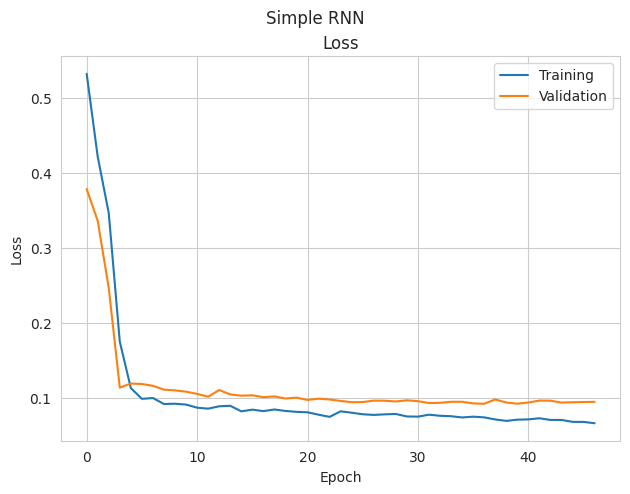

In [32]:
# Show training and validation curves
loss_acc_plot(history_model_RNN_simple,"Simple RNN")

We observe that the loss for the test set is significantly higher than for the training set, especially in the later epochs. As we will see further below, this apparent overfitting could be due to the fact that the structure of the time series changes drastically in 2020 and 2021, coinciding with the Covid pandemic.

In [33]:
# Predict 
predict_RNN_simple = model_RNN_simple.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


In [34]:
# Subset the last 24 rows of the dataset
df_test = df.iloc[-24:]

# Add the predictions from the simple RNN
df_test["RNN_simple_sentiment"] = predict_RNN_simple[:,0]
df_test["RNN_simple_ip"] = predict_RNN_simple[:,1]

In [35]:
# Show the result
df_test

,min-max_sentiment,min-max_ip,RNN_simple_sentiment,RNN_simple_ip
DATE,,,,
2022-01-01,0.404791,0.565950,0.465163,0.550106
2022-02-01,0.362148,0.685500,0.454818,0.536123
2022-03-01,0.193704,0.633995,0.436188,0.566843
2022-04-01,0.251929,0.609546,0.363183,0.547206
2022-05-01,0.201115,0.604075,0.376029,0.503635
2022-06-01,0.000000,0.591963,0.381108,0.507705
2022-07-01,0.087673,0.584146,0.311988,0.477983
2022-08-01,0.375504,0.586329,0.308279,0.476224
2022-09-01,0.345154,0.625328,0.464722,0.545712


Text(0.5, 1.08, 'Real and predicted values, simple RNN')

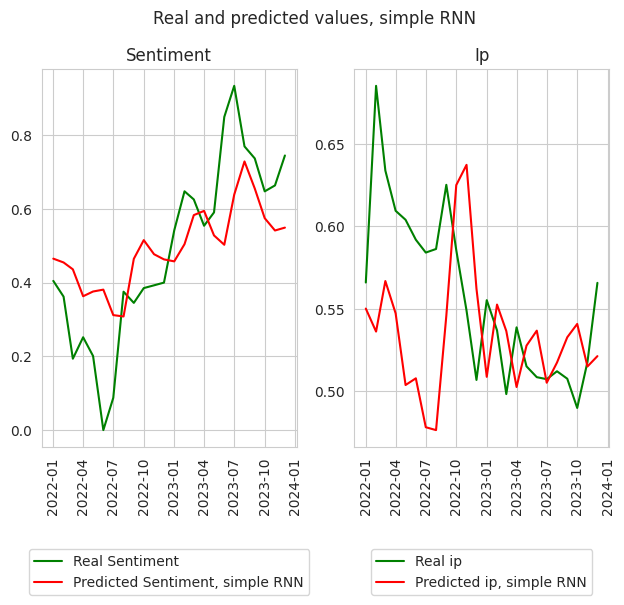

In [36]:
# Show the graphs
fig, ax = plt.subplots(1,2)
fig.tight_layout()
ax[0].plot(df_test["min-max_sentiment"], color="green", label="Real Sentiment")
ax[0].plot(df_test["RNN_simple_sentiment"], color="red", label="Predicted Sentiment, simple RNN")
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("Sentiment")
box0 = ax[0].get_position()
ax[0].set_position([box0.x0, box0.y0 + box0.height * 0.1,
                    box0.width, box0.height * 0.9])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

ax[1].plot(df_test["min-max_ip"], color="green", label="Real ip")
ax[1].plot(df_test["RNN_simple_ip"], color="red", label="Predicted ip, simple RNN")
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title("Ip")
box1 = ax[1].get_position()
ax[1].set_position([box1.x0, box1.y0 + box1.height * 0.1,
                    box1.width, box1.height * 0.9])
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

fig.suptitle("Real and predicted values, simple RNN", y=1.08)

We observe that the predictions are quite poor and worse for one of the two variables compared to the other. One way to address this issue could be to allow the model to train for more epochs (by increasing the `patience` value in the EarlyStopping callback), even at the risk of incurring more overfitting.

## 3.1. RNN with dataset truncated until 2019

Now we demonstrate what happens when we remove the more "noisy" years caused by Covid and truncate the dataset to end in 2019. An equivalent model to the previous one is trained but using the shortened dataset:

In [37]:
K.clear_session()

# Input and output for all models with two variables
n_features = output_size = 2

# Define model
model_RNN_simple_short = Sequential()
model_RNN_simple_short.add(tf.keras.layers.Input(shape=(window_size,n_features)))
model_RNN_simple_short.add(tf.keras.layers.SimpleRNN(units=12, dropout=0.1, return_sequences=False))
model_RNN_simple_short.add(tf.keras.layers.Dense(units=6, activation="relu"))
model_RNN_simple_short.add(tf.keras.layers.Dense(units=output_size, activation="linear"))

# Compile
model_RNN_simple_short.compile(optimizer="RMSProp", loss="mae")
model_RNN_simple_short.summary()

start = time.time()
# Training

# Callback for Early stopping
early_stopping_model_RNN_simple_short = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10)

# Model training
history_model_RNN_simple_short = model_RNN_simple_short.fit(
    x=X_train_short,
    y=y_train_short,
    epochs=100,
    batch_size=20,
    callbacks=[early_stopping_model_RNN_simple_short],
    shuffle=False,
    validation_data=(X_test_short, y_test_short))

print("Training time: "+str(time.time()-start)+" seconds")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 12)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272 (1.06 KB)

 Trainable params: 272 (1.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.5320 - val_loss: 0.2955
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3875 - val_loss: 0.1939
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2839 - val_loss: 0.1350
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2178 - val_loss: 0.0755
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1549 - val_loss: 0.0369
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1190 - val_loss: 0.0404
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1089 - val_loss: 0.0392
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1039 - val_loss: 0.0394
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1036 - val_loss: 0.0384
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0952 - val_loss: 0.0383
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0929 - val_loss: 0.0375
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

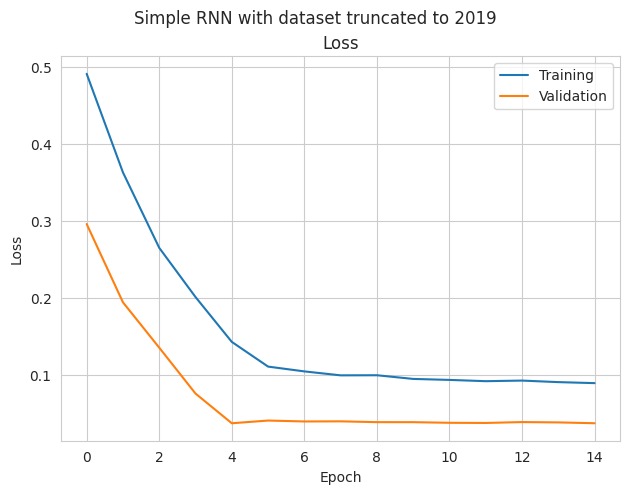

In [38]:
# Show training and validation curves
loss_acc_plot(history_model_RNN_simple_short,"Simple RNN with dataset truncated to 2019")

We observe that the validation curve now clearly falls below the training curve, likely due to the dropout in the SimpleRNN layer, which affects the training loss but not the validation loss. I believe a result like this is what we could expect if the structure of the time series were stable, as is the case when truncating at 2019.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Text(0.5, 1.08, 'Real and predicted values, simple RNN, dataset truncated to 2019')

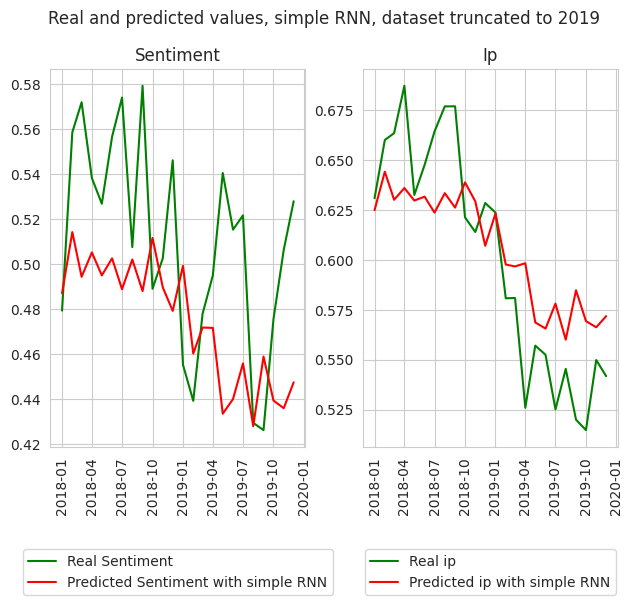

In [39]:
# Predict 
predict_RNN_simple_short = model_RNN_simple_short.predict(X_test_short)

# Subset last 24 rows of the dataset
df_test_short = df_short.iloc[-24:]

# Add the predictions
df_test_short["RNN_simple_sentiment"] = predict_RNN_simple_short[:,0]
df_test_short["RNN_simple_ip"] = predict_RNN_simple_short[:,1]

# Show comparison
fig, ax = plt.subplots(1,2)
fig.tight_layout()
ax[0].plot(df_test_short["min-max_sentiment"], color="green", label="Real Sentiment")
ax[0].plot(df_test_short["RNN_simple_sentiment"], color="red", label="Predicted Sentiment with simple RNN")
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("Sentiment")
box0 = ax[0].get_position()
ax[0].set_position([box0.x0, box0.y0 + box0.height * 0.1,
                    box0.width, box0.height * 0.9])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

ax[1].plot(df_test_short["min-max_ip"], color="green", label="Real ip")
ax[1].plot(df_test_short["RNN_simple_ip"], color="red", label="Predicted ip with simple RNN")
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title("Ip")
box1 = ax[1].get_position()
ax[1].set_position([box1.x0, box1.y0 + box1.height * 0.1,
                    box1.width, box1.height * 0.9])
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

fig.suptitle("Real and predicted values, simple RNN, dataset truncated to 2019", y=1.08)

We observe that when we remove the noisiest part at the end of the dataset, the result is much better for at least one of the two variables (though the challenge of training and predicting with two variables simultaneously still remains).

## 3.2. RNN with the complete dataset (up to 2023) but separated by variables

Now let's see if the predictions improve when we split the dataset into two, one for each variable. Once again, we maintain the same structure for the neural network, simply **changing the values for `n_features` and `output_size`**  
First, for the variable Sentiment

In [40]:
K.clear_session()

# Input and output are now 1
n_features = output_size = 1

# Define model
model_RNN_simple_sentiment = Sequential()
model_RNN_simple_sentiment.add(tf.keras.layers.Input(shape=(window_size,n_features)))
model_RNN_simple_sentiment.add(tf.keras.layers.SimpleRNN(units=12, dropout=0.1, return_sequences=False))
model_RNN_simple_sentiment.add(tf.keras.layers.Dense(units=6, activation="relu"))
model_RNN_simple_sentiment.add(tf.keras.layers.Dense(units=output_size, activation="linear"))

# Compile
model_RNN_simple_sentiment.compile(optimizer="RMSProp", loss="mae")
model_RNN_simple_sentiment.summary()

start = time.time()
# Training

# Callback for Early stopping
early_stopping_model_RNN_simple_sentiment = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10)

# Training 
history_model_RNN_simple_sentiment = model_RNN_simple_sentiment.fit(
    x=X_train_sentiment,
    y=y_train_sentiment,
    epochs=100,
    batch_size=20,
    callbacks=[early_stopping_model_RNN_simple_sentiment],
    shuffle=False,
    validation_data=(X_test_sentiment, y_test_sentiment))

print("Training time: "+str(time.time()-start)+" seconds")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 12)             │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253 (1012.00 B)

 Trainable params: 253 (1012.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.3976 - val_loss: 0.1812
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1120 - val_loss: 0.1600
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0973 - val_loss: 0.1489
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1010 - val_loss: 0.1299
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0869 - val_loss: 0.1265
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0896 - val_loss: 0.1261
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0886 - val_loss: 0.1300
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0812 - val_loss: 0.1347
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0779 - val_loss: 0.1345
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0802 - val_loss: 0.1349
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0804 - val_loss: 0.1334
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

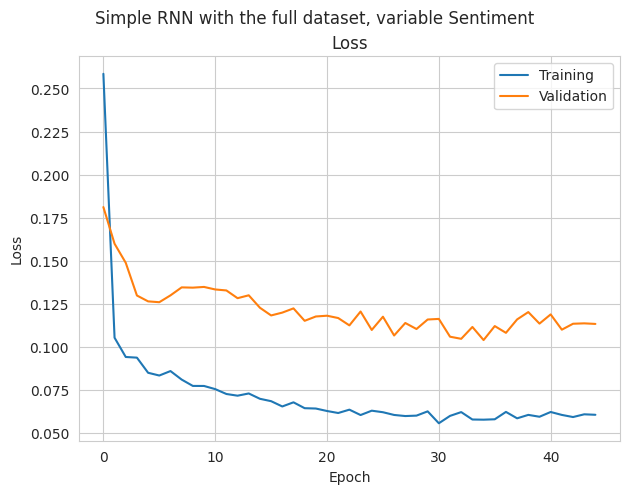

In [41]:
# Show training and validation curves
loss_acc_plot(history_model_RNN_simple_sentiment,"Simple RNN with the full dataset, variable Sentiment")

We again see the loss curve for the validation set significantly above that of the training set, once more because we are using all the data, including the noisiest part of the dataset.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Text(0.5, 1.08, 'Real and predicted values for the simple RNN for the variable Sentiment')

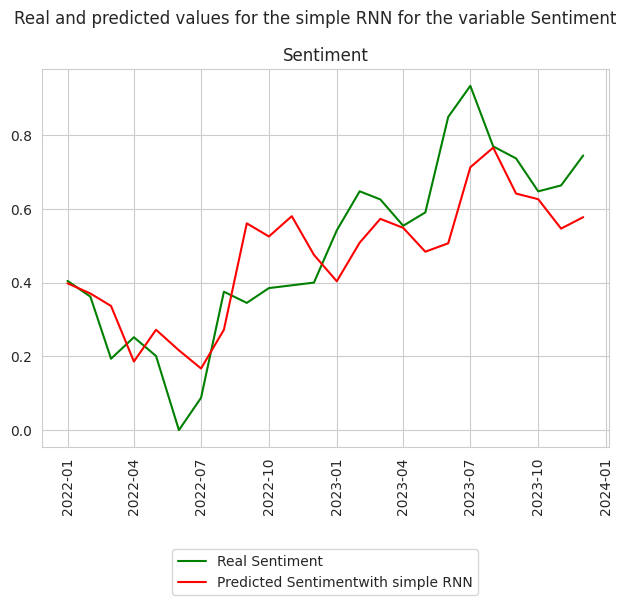

In [42]:
# Predict 
predict_RNN_simple_sentiment = model_RNN_simple_sentiment.predict(X_test_sentiment)

# Subset the last 24 rows of the dataset
df_test_sentiment = df.drop(["min-max_ip"], axis=1).iloc[-24:]

# Add predictions from the simple RNN
df_test_sentiment["RNN_simple_sentiment"] = predict_RNN_simple_sentiment[:,0]

# Show comparison
fig, ax = plt.subplots()
fig.tight_layout()
ax.plot(df_test_sentiment["min-max_sentiment"], color="green", label="Real Sentiment")
ax.plot(df_test_sentiment["RNN_simple_sentiment"], color="red", label="Predicted Sentimentwith simple RNN")
ax.tick_params(axis='x', rotation=90)
ax.set_title("Sentiment")
box0 = ax.get_position()
ax.set_position([box0.x0, box0.y0 + box0.height * 0.1,
                    box0.width, box0.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

fig.suptitle("Real and predicted values for the simple RNN for the variable Sentiment", y=1.08)

We can see that, while not perfect, the prediction for this variable separately is better than for the same variable when attempting to predict both together.

I will now continue with the variable ip.

In [43]:
K.clear_session()

# Input and output are now 1
n_features = output_size = 1

# Define the model
model_RNN_simple_ip = Sequential()
model_RNN_simple_ip.add(tf.keras.layers.Input(shape=(window_size,n_features)))
model_RNN_simple_ip.add(tf.keras.layers.SimpleRNN(units=12, dropout=0.1, return_sequences=False))
model_RNN_simple_ip.add(tf.keras.layers.Dense(units=6, activation="relu"))
model_RNN_simple_ip.add(tf.keras.layers.Dense(units=output_size, activation="linear"))

# Compile
model_RNN_simple_ip.compile(optimizer="RMSProp", loss="mae")
model_RNN_simple_ip.summary()

start = time.time()
# Training

# Callback for Early stopping
early_stopping_model_RNN_simple_ip = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10)

# Training
history_model_RNN_simple_ip = model_RNN_simple_ip.fit(
    x=X_train_ip,
    y=y_train_ip,
    epochs=100,
    batch_size=20,
    callbacks=[early_stopping_model_RNN_simple_ip],
    shuffle=False,
    validation_data=(X_test_ip, y_test_ip))

print("Training time: "+str(time.time()-start)+" seconds")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 12)             │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253 (1012.00 B)

 Trainable params: 253 (1012.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 1.2504 - val_loss: 0.7034
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6536 - val_loss: 0.4987
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5270 - val_loss: 0.4737
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4708 - val_loss: 0.3272
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3231 - val_loss: 0.1603
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1697 - val_loss: 0.0401
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0885 - val_loss: 0.0393
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0849 - val_loss: 0.0390
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0869 - val_loss: 0.0386
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0845 - val_loss: 0.0384
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0837 - val_loss: 0.0382
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

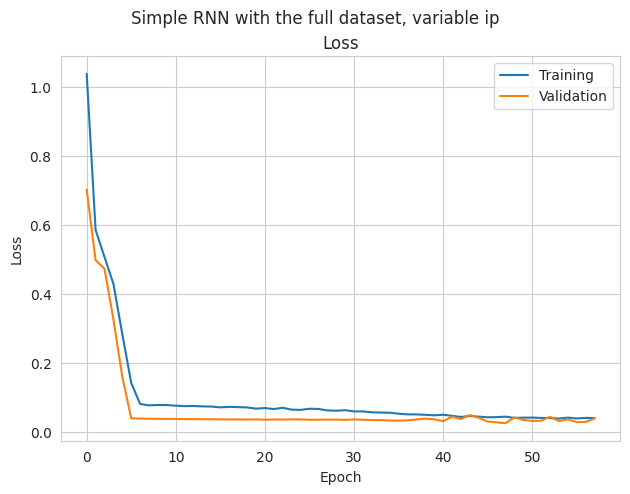

In [44]:
# Show training and validation curves
loss_acc_plot(history_model_RNN_simple_ip,"Simple RNN with the full dataset, variable ip")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Text(0.5, 1.08, 'Real and predicted values for the simple RNN for the variable ip')

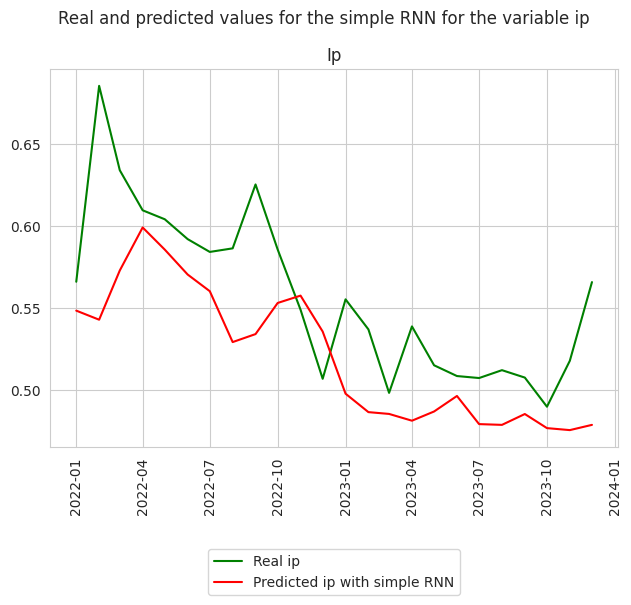

In [45]:
# Predict 
predict_RNN_simple_ip = model_RNN_simple_ip.predict(X_test_ip)

# Subset the last 24 rows of the dataset
df_test_ip = df.drop(["min-max_sentiment"], axis=1).iloc[-24:]

# Add predictions from the simple RNN model
df_test_ip["RNN_simple_ip"] = predict_RNN_simple_ip[:,0]

# Mostrar las gráficas
fig, ax = plt.subplots()
fig.tight_layout()
ax.plot(df_test_ip["min-max_ip"], color="green", label="Real ip")
ax.plot(df_test_ip["RNN_simple_ip"], color="red", label="Predicted ip with simple RNN")
ax.tick_params(axis='x', rotation=90)
ax.set_title("Ip")
box0 = ax.get_position()
ax.set_position([box0.x0, box0.y0 + box0.height * 0.1,
                    box0.width, box0.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

fig.suptitle("Real and predicted values for the simple RNN for the variable ip", y=1.08)

Once again, we have a good prediction compared to what we saw when trying to predict both variables together. A recurring observation is that when training takes more epochs (i.e., early stopping takes longer to trigger), the result tends to be better.








## 3.3. Increasing `patience`

Is there a way to solve this issue? I believe that increasing the value of patience results in better convergence of the models, and the predictions improve when we use the complete dataset (up to 2023) with both variables simultaneously. We could perform a quick test by completely removing the `EarlyStopping` callback.

In [46]:
K.clear_session()

# Input and output for all models with two variables
n_features = output_size = 2

# Define model
model_RNN_simple_more_patience = Sequential()
model_RNN_simple_more_patience.add(tf.keras.layers.Input(shape=(window_size,n_features)))
model_RNN_simple_more_patience.add(tf.keras.layers.SimpleRNN(units=12, dropout=0.1, return_sequences=False))
model_RNN_simple_more_patience.add(tf.keras.layers.Dense(units=6, activation="relu"))
model_RNN_simple_more_patience.add(tf.keras.layers.Dense(units=output_size, activation="linear"))

# Compile
model_RNN_simple_more_patience.compile(optimizer="RMSProp", loss="mae")
model_RNN_simple_more_patience.summary()

start = time.time()

# Training
history_model_RNN_simple_more_patience = model_RNN_simple_more_patience.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=20,
    shuffle=False,
    validation_data=(X_test, y_test))

print("Training time: "+str(time.time()-start)+" seconds")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 12)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272 (1.06 KB)

 Trainable params: 272 (1.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.1244 - val_loss: 0.1356
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0908 - val_loss: 0.1353
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0862 - val_loss: 0.1334
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0880 - val_loss: 0.1345
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0897 - val_loss: 0.1397
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0808 - val_loss: 0.1368
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0840 - val_loss: 0.1344
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0801 - val_loss: 0.1390
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0771 - val_loss: 0.1351
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0799 - val_loss: 0.1324
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0787 - val_loss: 0.1333
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

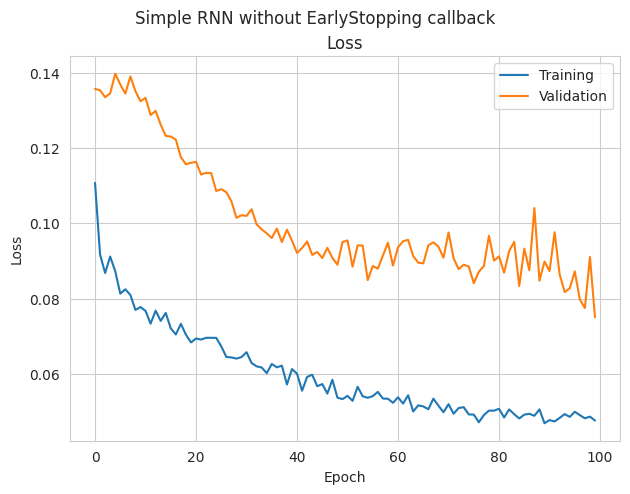

In [47]:
# Show training and validation curves
loss_acc_plot(history_model_RNN_simple_more_patience,"Simple RNN without EarlyStopping callback")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Text(0.5, 1.08, 'Real and predicted values without EarlyStopping callback')

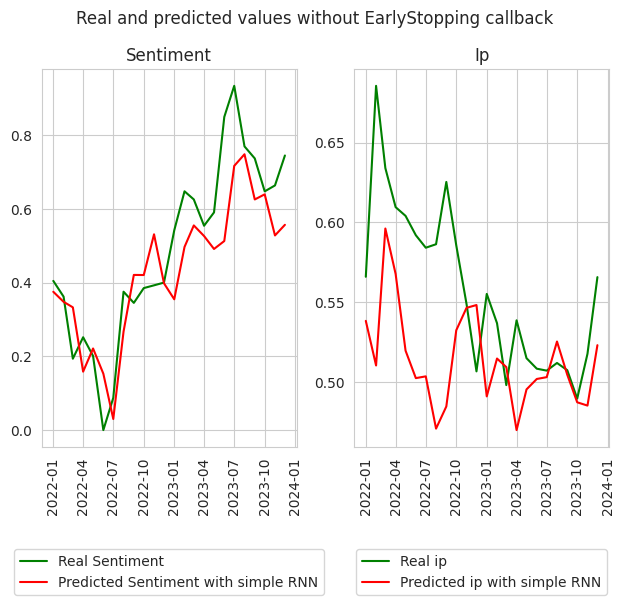

In [48]:
# Predict 
predict_RNN_simple_more_patience = model_RNN_simple_more_patience.predict(X_test)

# Subset the last 24 rows of the dataset
df_test_more_patience = df.iloc[-24:]

# Add predictions from the simple RNN
df_test_more_patience["RNN_simple_sentiment"] = predict_RNN_simple_more_patience[:,0]
df_test_more_patience["RNN_simple_ip"] = predict_RNN_simple_more_patience[:,1]

# Show comparison
fig, ax = plt.subplots(1,2)
fig.tight_layout()
ax[0].plot(df_test_more_patience["min-max_sentiment"], color="green", label="Real Sentiment")
ax[0].plot(df_test_more_patience["RNN_simple_sentiment"], color="red", label="Predicted Sentiment with simple RNN")
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("Sentiment")
box0 = ax[0].get_position()
ax[0].set_position([box0.x0, box0.y0 + box0.height * 0.1,
                    box0.width, box0.height * 0.9])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

ax[1].plot(df_test_more_patience["min-max_ip"], color="green", label="Real ip")
ax[1].plot(df_test_more_patience["RNN_simple_ip"], color="red", label="Predicted ip with simple RNN")
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title("Ip")
box1 = ax[1].get_position()
ax[1].set_position([box1.x0, box1.y0 + box1.height * 0.1,
                    box1.width, box1.height * 0.9])
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

fig.suptitle("Real and predicted values without EarlyStopping callback", y=1.08)

We observe that removing the `EarlyStopping` callback improves the result. However, even though only one training instance is shown here, there is significant variability if we repeat the training from scratch multiple times.

## 4. GRU

GRU (Gated Recurrent Unit) is a type of RNN designed to handle sequential data efficiently. It uses two *gates* (reset and update) to control information flow, retaining long-term dependencies while being faster and easier to train. Let's implement a GRU-based NN for our predictions:

In [49]:
K.clear_session()

# Input and output for all models with two variables
n_features = output_size = 2

# Define model
model_GRU = Sequential()
model_GRU.add(tf.keras.layers.Input(shape=(6,n_features)))
model_GRU.add(tf.keras.layers.GRU(units=16, 
                                  dropout=0.1, 
                                  recurrent_dropout=0.1, 
                                  return_sequences=False))
model_GRU.add(tf.keras.layers.Dense(units=8, activation="relu"))
model_GRU.add(tf.keras.layers.Dense(units=output_size, activation="linear"))

In [50]:
# Compile
model_GRU.compile(optimizer="RMSProp", loss="mae")
model_GRU.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 16)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,114 (4.35 KB)

 Trainable params: 1,114 (4.35 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
start = time.time()
# Training

# Callback for Early stopping
early_stopping_model_GRU = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10)

# Callback for Model checkpoint
checkpoint_filepath = Path(results_path, 'gru.h5.keras')

model_checkpoint_model_GRU = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_loss",
    save_best_only=True)

# Entrenar el modelo
history_model_GRU = model_GRU.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=20,
    callbacks=[early_stopping_model_GRU, model_checkpoint_model_GRU],
    shuffle=False,
    validation_data=(X_test, y_test))

print("Training time: "+str(time.time()-start)+" seconds")

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.5325 - val_loss: 0.1613
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1394 - val_loss: 0.1127
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1185 - val_loss: 0.1156
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1092 - val_loss: 0.1113
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1084 - val_loss: 0.1048
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1037 - val_loss: 0.1076
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0961 - val_loss: 0.1082
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0935 - val_loss: 0.1137
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0963 - val_loss: 0.1062
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0906 - val_loss: 0.1032
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0894 - val_loss: 0.1065
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

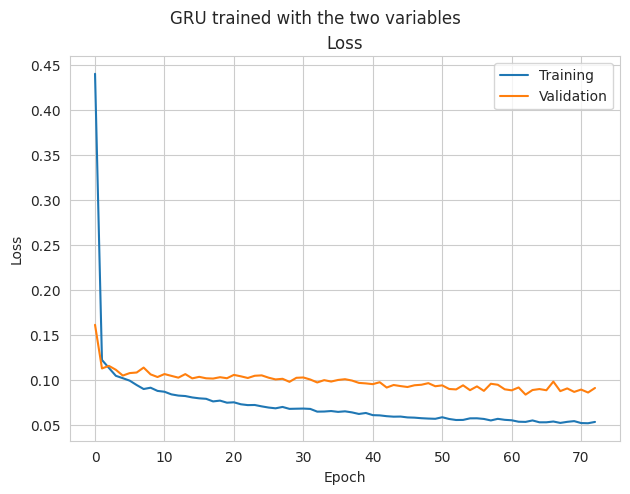

In [52]:
# Training and validation curves
loss_acc_plot(history_model_GRU,"GRU trained with the two variables")

In [54]:
# Predict
predict_GRU = model_GRU.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


In [55]:
# Add predictions of GRU NN
df_test["GRU_sentiment"] = predict_GRU[:,0]
df_test["GRU_ip"] = predict_GRU[:,1]

Text(0.5, 1.08, 'Real and predicted values with GRU')

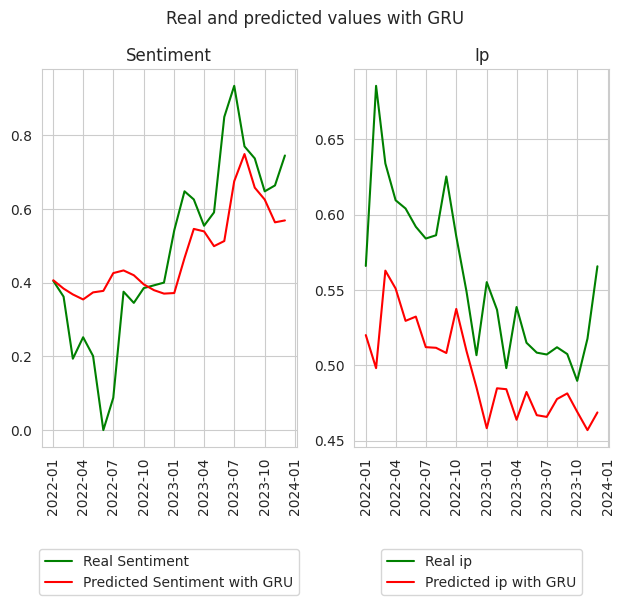

In [57]:
# Show comparison
fig, ax = plt.subplots(1,2)
fig.tight_layout()
ax[0].plot(df_test["min-max_sentiment"], color="green", label="Real Sentiment")
ax[0].plot(df_test["GRU_sentiment"], color="red", label="Predicted Sentiment with GRU")
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("Sentiment")
box0 = ax[0].get_position()
ax[0].set_position([box0.x0, box0.y0 + box0.height * 0.1,
                    box0.width, box0.height * 0.9])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

ax[1].plot(df_test["min-max_ip"], color="green", label="Real ip")
ax[1].plot(df_test["GRU_ip"], color="red", label="Predicted ip with GRU")
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title("Ip")
box1 = ax[1].get_position()
ax[1].set_position([box1.x0, box1.y0 + box1.height * 0.1,
                    box1.width, box1.height * 0.9])
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

fig.suptitle("Real and predicted values with GRU", y=1.08)

## 5. LSTM 

LSTM (Long Short-Term Memory) is a type of RNN designed to learn long-term dependencies. It uses three gates (input, forget, and output) to manage information flow, enabling it to retain relevant information over long sequences while filtering out unnecessary details, making it powerful for sequential data tasks. Here the implementation for our dataset:

In [58]:
K.clear_session()

# Input and output for all models with two variables
n_features = output_size = 2

# Define model
model_LSTM = Sequential()
model_LSTM.add(tf.keras.layers.Input(shape=(6,n_features)))
model_LSTM.add(tf.keras.layers.LSTM(units=12, 
                                    dropout=0.1,
                                    recurrent_dropout=0.1,
                                    return_sequences=False))
model_LSTM.add(tf.keras.layers.Dense(units=6, activation="relu"))
model_LSTM.add(tf.keras.layers.Dense(units=output_size, activation="linear"))

In [59]:
# Compile
model_LSTM.compile(optimizer="RMSProp", loss="mae")
model_LSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12)             │           720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 812 (3.17 KB)

 Trainable params: 812 (3.17 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
start = time.time()
# Training

# Callback for Early stopping
early_stopping_model_LSTM = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10)

# Callback for Model checkpoint
checkpoint_filepath = Path(results_path, 'lstm.h5.keras')

model_checkpoint_model_LSTM = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_loss",
    save_best_only=True)

# Training
history_model_LSTM = model_LSTM.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=20,
    callbacks=[early_stopping_model_LSTM, model_checkpoint_model_LSTM],
    shuffle=False,
    validation_data=(X_test, y_test))

print("Training time: "+str(time.time()-start)+" seconds")

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.5927 - val_loss: 0.4853
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5092 - val_loss: 0.3358
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2883 - val_loss: 0.1444
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1017 - val_loss: 0.1291
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0978 - val_loss: 0.1293
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1014 - val_loss: 0.1285
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1006 - val_loss: 0.1257
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1045 - val_loss: 0.1239
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0961 - val_loss: 0.1241
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0944 - val_loss: 0.1224
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0940 - val_loss: 0.1224
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.

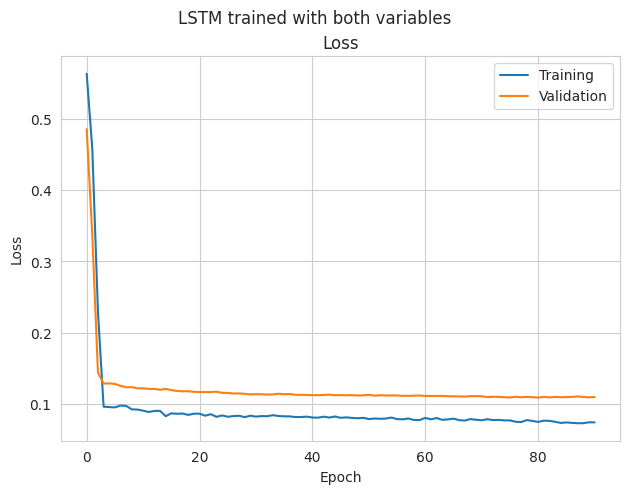

In [61]:
# Show training and validation curves
loss_acc_plot(history_model_LSTM,"LSTM trained with both variables")

In [62]:
# Predict 
predict_LSTM = model_LSTM.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


In [63]:
# Add predictions from LSTM
df_test["LSTM_sentiment"] = predict_LSTM[:,0]
df_test["LSTM_ip"] = predict_LSTM[:,1]

Text(0.5, 1.08, 'Real and predicted values with LSTM')

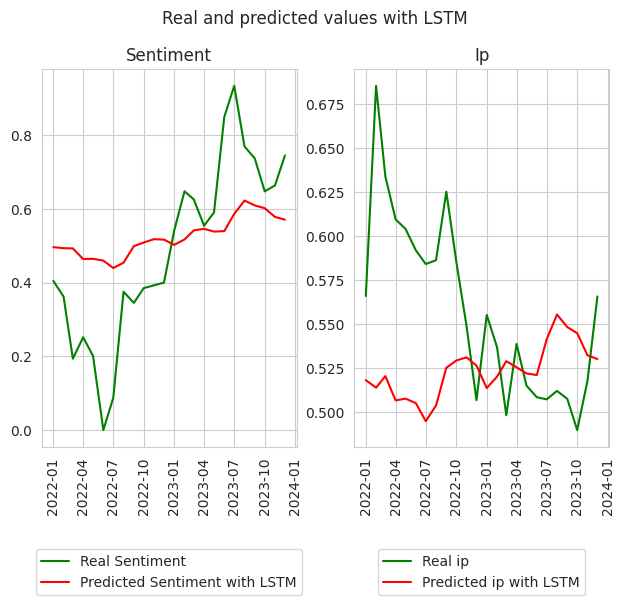

In [64]:
# Show comparison
fig, ax = plt.subplots(1,2)
fig.tight_layout()
ax[0].plot(df_test["min-max_sentiment"], color="green", label="Real Sentiment")
ax[0].plot(df_test["LSTM_sentiment"], color="red", label="Predicted Sentiment with LSTM")
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("Sentiment")
box0 = ax[0].get_position()
ax[0].set_position([box0.x0, box0.y0 + box0.height * 0.1,
                    box0.width, box0.height * 0.9])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

ax[1].plot(df_test["min-max_ip"], color="green", label="Real ip")
ax[1].plot(df_test["LSTM_ip"], color="red", label="Predicted ip with LSTM")
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title("Ip")
box1 = ax[1].get_position()
ax[1].set_position([box1.x0, box1.y0 + box1.height * 0.1,
                    box1.width, box1.height * 0.9])
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))

fig.suptitle("Real and predicted values with LSTM", y=1.08)

In contrast with expectations, predictions with the LSTM are worse than with the GRU or the simple RNN